In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0628/weights_KD_segformer_0628_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

Position_Embedding_0628_teacher_0.01
FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - loss: 0.0730
Average validation loss: 0.6201676726341248
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - loss: 0.0730 - val_loss: 0.6202
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 496ms/step - loss: 0.0526 - val_loss: 0.6202
Average validation loss: 0.6875314712524414
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 510ms/step - loss: 0.0526 - val_loss: 0.6538
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 501ms/step - loss: 0.0406 - val_loss: 0.6538
Average validation loss: 0.6832883358001709
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 513ms/step - loss: 0.0406 - val_loss: 0.6637
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 503ms/step - loss: 0.0325 - val_loss: 0.6637
Average validation loss: 0.49562376737594604
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 514ms/step - loss: 0.0325 - val_loss: 0.6217
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weight

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 865ms/step - loss: 2.6252e-04
Average validation loss: 0.16949636861681938
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 880ms/step - loss: 2.6252e-04 - val_loss: 0.1695
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 911ms/step - loss: 2.3541e-04 - val_loss: 0.1695
Average validation loss: 0.1827632673084736
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 926ms/step - loss: 2.3541e-04 - val_loss: 0.1761
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 854ms/step - loss: 2.2531e-04 - val_loss: 0.1761
Average validation loss: 0.11431631445884705
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 866ms/step - loss: 2.2531e-04 - val_loss: 0.1555
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_10.pth'.
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 859ms/step - loss: 2.1599e-04 - val_loss: 0.1555
Averag

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 805ms/step - loss: 1.2463e-04
Average validation loss: 0.028356346301734447
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 817ms/step - loss: 1.2463e-04 - val_loss: 0.0284
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 810ms/step - loss: 1.0593e-04 - val_loss: 0.0284
Average validation loss: 0.0798359786470731
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 823ms/step - loss: 1.0593e-04 - val_loss: 0.0541
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 800ms/step - loss: 9.6697e-05 - val_loss: 0.0541
Average validation loss: 0.02912123113249739
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 814ms/step - loss: 9.6697e-05 - val_loss: 0.0458
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 809ms/step - loss: 1.1425e-04 - val_loss: 0.0458
Average validation loss: 0.043993803672492504
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 822ms/step - loss: 1.1425e-04 - val_loss: 0.0453
Epoch 5/10
12/

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 912ms/step - loss: 1.2939e-05
Average validation loss: 0.04001608060207218
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 924ms/step - loss: 1.2939e-05 - val_loss: 0.0400
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 808ms/step - loss: 1.1821e-05 - val_loss: 0.0400
Average validation loss: 0.02096303994767368
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 818ms/step - loss: 1.1821e-05 - val_loss: 0.0305
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 783ms/step - loss: 1.0807e-05 - val_loss: 0.0305
Average validation loss: 0.008886625873856246
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 795ms/step - loss: 1.0807e-05 - val_loss: 0.0233
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_s

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 818ms/step - loss: 5.1843e-05
Average validation loss: 0.01896530338563025
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 828ms/step - loss: 5.1843e-05 - val_loss: 0.0190
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 907ms/step - loss: 3.9267e-05 - val_loss: 0.0190
Average validation loss: 0.02737902645021677
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 918ms/step - loss: 3.9267e-05 - val_loss: 0.0232
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 785ms/step - loss: 3.1061e-05 - val_loss: 0.0232
Average validation loss: 0.009389723045751452
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 796ms/step - loss: 3.1061e-05 - val_loss: 0.0186
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 818ms/step - loss: 2.5355e-05 - val_l

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 816ms/step - loss: 4.5966e-05
Average validation loss: 0.01113185922925671
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 827ms/step - loss: 4.5966e-05 - val_loss: 0.0111
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 858ms/step - loss: 3.0551e-05 - val_loss: 0.0111
Average validation loss: 0.009363594464957714
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 869ms/step - loss: 3.0551e-05 - val_loss: 0.0102
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 794ms/step - loss: 2.3787e-05 - val_loss: 0.0102
Average validation loss: 0.005602821533102542
24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 805ms/step - loss: 2.3787e-05 - val_loss: 0.0087
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 791ms/step - loss: 4.2607e-05
Average validation loss: 0.016392913897288964
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 803ms/step - loss: 4.2607e-05 - val_loss: 0.0164
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 779ms/step - loss: 3.1910e-05 - val_loss: 0.0164
Average validation loss: 0.01477675240021199
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 791ms/step - loss: 3.1910e-05 - val_loss: 0.0156
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 781ms/step - loss: 2.5706e-05 - val_loss: 0.0156
Average validation loss: 0.017789124057162552
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 794ms/step - loss: 2.5706e-05 - val_loss: 0.0163
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 127s 785ms/step - loss: 2.1126e-05 - val

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 829ms/step - loss: 1.8513e-05
Average validation loss: 0.01729541962655882
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 841ms/step - loss: 1.8513e-05 - val_loss: 0.0173
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 876ms/step - loss: 1.2971e-05 - val_loss: 0.0173
Average validation loss: 0.00858744869280296
48/48 ━━━━━━━━━━━━━━━━━━━━ 83s 888ms/step - loss: 1.2971e-05 - val_loss: 0.0129
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 121s 795ms/step - loss: 9.8981e-06 - val_loss: 0.0129
Average validation loss: 0.008158999757142738
48/48 ━━━━━━━━━━━━━━━━━━━━ 122s 807ms/step - loss: 9.8981e-06 - val_loss: 0.0113
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 795ms/step - loss: 1.0901e-05
Average validation loss: 0.00885877846407571
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 807ms/step - loss: 1.0901e-05 - val_loss: 0.0089
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 804ms/step - loss: 7.1477e-06 - val_loss: 0.0089
Average validation loss: 0.007971091013002609
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 816ms/step - loss: 7.1477e-06 - val_loss: 0.0084
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 807ms/step - loss: 5.7358e-06 - val_loss: 0.0084
Average validation loss: 0.009440787003508635
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 819ms/step - loss: 5.7358e-06 - val_loss: 0.0088
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 182s 810ms/step - loss: 4.8267e-06 - v

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 805ms/step - loss: 8.8498e-06
Average validation loss: 0.009354816647828557
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 818ms/step - loss: 8.8498e-06 - val_loss: 0.0094
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 781ms/step - loss: 8.6933e-06 - val_loss: 0.0094
Average validation loss: 0.013569281116360798
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 793ms/step - loss: 8.6933e-06 - val_loss: 0.0115
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 787ms/step - loss: 7.0434e-06 - val_loss: 0.0115
Average validation loss: 0.008922263878048398
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 798ms/step - loss: 7.0434e-06 - val_loss: 0.0106
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_80.pth'.
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 204s 781ms/step - loss: 5.8701e-06 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 782ms/step - loss: 3.4337e-06
Average validation loss: 0.011699867877824646
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 794ms/step - loss: 3.4337e-06 - val_loss: 0.0117
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 798ms/step - loss: 2.6880e-06 - val_loss: 0.0117
Average validation loss: 0.011471852789529495
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 809ms/step - loss: 2.6880e-06 - val_loss: 0.0116
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 172s 791ms/step - loss: 2.1935e-06 - val_loss: 0.0116
Average validation loss: 0.00975786709265473
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 802ms/step - loss: 2.1935e-06 - val_loss: 0.0110
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 782ms/step - loss: 4.1452e-06
Average validation loss: 0.00576056182035245
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 793ms/step - loss: 4.1452e-06 - val_loss: 0.0058
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 127s 798ms/step - loss: 3.1037e-06 - val_loss: 0.0058
Average validation loss: 0.004937505358248018
80/80 ━━━━━━━━━━━━━━━━━━━━ 128s 809ms/step - loss: 3.1037e-06 - val_loss: 0.0053
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 820ms/step - loss: 2.5307e-06 - val_loss: 0.0053
Average validation loss: 0.0052228901884518565
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 831ms/step - loss: 2.5307e-06 - val_loss: 0.0053
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 261s 822ms/step - loss: 2.2355e-0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 786ms/step - loss: 7.3920e-06
Average validation loss: 0.012490635272115469
96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 798ms/step - loss: 7.3920e-06 - val_loss: 0.0125
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 152s 780ms/step - loss: 9.9320e-06 - val_loss: 0.0125
Average validation loss: 0.010633787896949798
96/96 ━━━━━━━━━━━━━━━━━━━━ 153s 792ms/step - loss: 9.9320e-06 - val_loss: 0.0116
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 228s 782ms/step - loss: 7.9962e-06 - val_loss: 0.0116
Average validation loss: 0.014041939682404822
96/96 ━━━━━━━━━━━━━━━━━━━━ 229s 795ms/step - loss: 7.9962e-06 - val_loss: 0.0124
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 304s 779ms/step - loss: 6.6429e-0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 794ms/step - loss: 1.5622e-05
Average validation loss: 0.013445353841719528
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 806ms/step - loss: 1.5622e-05 - val_loss: 0.0134
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 191s 788ms/step - loss: 1.0276e-05 - val_loss: 0.0134
Average validation loss: 0.007403448813905319
120/120 ━━━━━━━━━━━━━━━━━━━━ 193s 799ms/step - loss: 1.0276e-05 - val_loss: 0.0104
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 289s 799ms/step - loss: 7.9372e-06 - val_loss: 0.0104
Average validation loss: 0.00692364921948562
120/120 ━━━━━━━━━━━━━━━━━━━━ 290s 811ms/step - loss: 7.9372e-06 - val_loss: 0.0093
Saved model weights to 'c:\天_11157065\git\RipplesDetection\w

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 785ms/step - loss: 1.4956e-05
Average validation loss: 0.009451215656655323
144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 797ms/step - loss: 1.4956e-05 - val_loss: 0.0095
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 227s 782ms/step - loss: 1.0246e-05 - val_loss: 0.0095
Average validation loss: 0.011207211914653372
144/144 ━━━━━━━━━━━━━━━━━━━━ 229s 793ms/step - loss: 1.0246e-05 - val_loss: 0.0103
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 342s 785ms/step - loss: 8.0701e-06 - val_loss: 0.0103
Average validation loss: 0.007258479053335678
144/144 ━━━━━━━━━━━━━━━━━━━━ 344s 796ms/step - loss: 8.0701e-06 - val_loss: 0.0093
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_180.pth'.
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 456s 781ms/step -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 780ms/step - loss: 5.2383e-06
Average validation loss: 0.008492091757943854
160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 791ms/step - loss: 5.2383e-06 - val_loss: 0.0085
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 250s 769ms/step - loss: 4.1069e-06 - val_loss: 0.0085
Average validation loss: 0.007749239876284264
160/160 ━━━━━━━━━━━━━━━━━━━━ 252s 780ms/step - loss: 4.1069e-06 - val_loss: 0.0081
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 382s 815ms/step - loss: 3.4391e-06 - val_loss: 0.0081
Average validation loss: 0.006866899505257607
160/160 ━━━━━━━━━━━━━━━━━━━━ 384s 826ms/step - loss: 3.4391e-06 - val_loss: 0.0077
Saved model weights to 'c:\天_11157065\git\RipplesDetectio

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 164s 822ms/step - loss: 4.4027e-06
Average validation loss: 0.006774529251269996
200/200 ━━━━━━━━━━━━━━━━━━━━ 167s 834ms/step - loss: 4.4027e-06 - val_loss: 0.0068
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 330s 819ms/step - loss: 3.3325e-06 - val_loss: 0.0068
Average validation loss: 0.007173728921625298
200/200 ━━━━━━━━━━━━━━━━━━━━ 333s 830ms/step - loss: 3.3325e-06 - val_loss: 0.0070
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 493s 800ms/step - loss: 2.8174e-06 - val_loss: 0.0070
Average validation loss: 0.005917005853116279
200/200 ━━━━━━━━━━━━━━━━━━━━ 495s 811ms/step - loss: 2.8174e-06 - val_loss: 0.0066
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_250.pth'.
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 655s 799ms/step -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 188s 785ms/step - loss: 3.9416e-06
Average validation loss: 0.0056828294570247335
240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 796ms/step - loss: 3.9416e-06 - val_loss: 0.0057
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 378s 778ms/step - loss: 3.0722e-06 - val_loss: 0.0057
Average validation loss: 0.00583536718798617
240/240 ━━━━━━━━━━━━━━━━━━━━ 380s 789ms/step - loss: 3.0722e-06 - val_loss: 0.0058
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 567s 777ms/step - loss: 2.5066e-06 - val_loss: 0.0058
Average validation loss: 0.005237334352568723
240/240 ━━━━━━━━━━━━━━━━━━━━ 570s 789ms/step - loss: 2.5066e-06 - val_loss: 0.0056
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0628/weights_KD_segformer_0628_20\segformer_data_size_300.pth'.
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 757s 779ms/step -

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.17152129501104355, 0.07017802633345127, 0.02610715092159808, 0.010628237026394345, 0.009416721619083546, 0.009364084745466244, 0.012751076876011212, 0.011202211465182093, 0.008020873205885955, 0.006298981005129462, 0.008392591292439544, 0.00491613337767194, 0.00613823198863732, 0.006892066704167519, 0.007855675409828886, 0.008253076856288656, 0.006914568813647565, 0.005294345917139215]
std_val_losses =  [0.15547201224700755, 0.04974848912952473, 0.01556165065478803, 0.007338642811806976, 0.005757796435699456, 0.005065755034308939, 0.007141913105724168, 0.011906336943386291, 0.004218459219586286, 0.002461849328174713, 0.011658588958246474, 0.0015607093549200124, 0.0032799639357708895, 0.002637318528364662, 0.002564462895940186, 0.008781923081160544, 0.002839953112421043, 0.0012054723426535646]


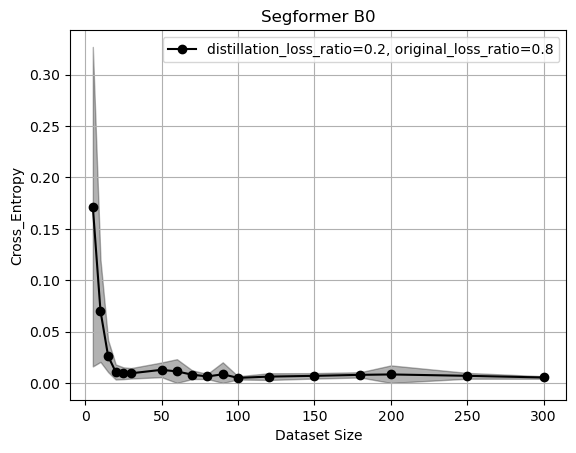

In [3]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0628')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0628_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0628_{int(teacher_ratio*100)}.png"))

plt.show()